In [5]:
import pandas as pd
import wbgapi as wb
import os
import pickle
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
import math

In [6]:
years = np.array([2004, 2006, 2008, 2009, 2011, 2013, 2015, 2017, 2019, 2021])

indicators = {
    "cpi": "FP.CPI.TOTL",
    "gdp": "NY.GDP.MKTP.KD",
    "regulatory": "RQ.EST",
    "tariff": "TM.TAX.TCOM.WM.AR.ZS",
    "fuel_exports": "TX.VAL.FUEL.ZS.UN",
    "fuel_imports": "TM.VAL.FUEL.ZS.UN",
    "labor_force_young": "SL.TLF.ACTI.1524.NE.ZS"
}

economies = {
    41: ["BRA", "URY", "ARG", "GBR"],
    61: ["CHN", "RUS", "JPN", "KOR", "PRK"],
    81: ["AUS", "NZL"],
}

In [7]:
def preprocess_wb_data(code, t, econ):
    r = wb.data.DataFrame(
            code, time=t, economy=econ
        )
    r = r.T.reset_index().rename(columns={"index": "Year"})
    r["Year"] = [int(y[2:]) for y in r["Year"]]
    for col in r.columns:
        if col != "Year":
            r[col] = r[col].interpolate()

    return r.dropna(axis=1)

In [8]:
wb_data = {}

for indicator, code in indicators.items():
    wb_data[indicator] = {}
    for area, econ in economies.items():
        wb_data[indicator][area] = preprocess_wb_data(code, years, econ)

In [9]:
with open(
    os.path.dirname(os.getcwd()) + "/conversions/area_names_map.pkl", "rb"
) as file:
    area_map = pickle.load(file)

with open(
    os.path.dirname(os.getcwd()) + "/model_data/target_data_prototype.pkl", "rb"
) as file:
    target_data = pickle.load(file)

In [10]:
def regular_ave(data, area):
    r = data.copy()
    r["Ave"] = r[[col for col in r.columns if col != "Year"]].mean(axis=1)
    r["Area"] = [area] * len(r)
    return r[["Year", "Ave", "Area"]]

In [11]:
def indicator_report1(indicator_data, indicator_name, target_data):
    comb = pd.DataFrame()

    for area, data in indicator_data.items():
        r = regular_ave(data, area)

        if comb.empty:
            comb = r
        else:
            comb = pd.concat([comb, r])

    full_data = pd.merge(target_data, comb, how="inner", on=["Year", "Area"])

    sc = StandardScaler()
    full_data[indicator_name] = sc.fit_transform(full_data["Ave"].to_frame())
    full_data.drop(columns="Ave", inplace=True)
    full_data = full_data.sort_values(by=["Area", "Year"]).reset_index(drop=True)

    ind = sm.cov_struct.Autoregressive()
    fam = sm.families.Binomial()
    model1 = smf.gee(f"S ~ {indicator_name}", "Area", full_data, cov_struct=ind).fit()
    print(model1.summary())

    fig = sm.qqplot(model1.resid, stats.t, fit=True, line="45")
    plt.title(f"Residuals for {indicator_name}")
    plt.show()

    return sc

In [12]:
scalers = {}

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/genmod/cov_struct.py:796: FutureWarning: grid=True will become default in a future version
  warnings.warn(


                               GEE Regression Results                              
Dep. Variable:                           S   No. Observations:                   30
Model:                                 GEE   No. clusters:                        3
Method:                        Generalized   Min. cluster size:                  10
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                10.0
Dependence structure:       Autoregressive   Num. iterations:                     8
Date:                     Mon, 30 Dec 2024   Scale:                           0.021
Covariance type:                    robust   Time:                         11:34:32
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7093      0.046     15.448      0.000       0.619       0.799
cpi    

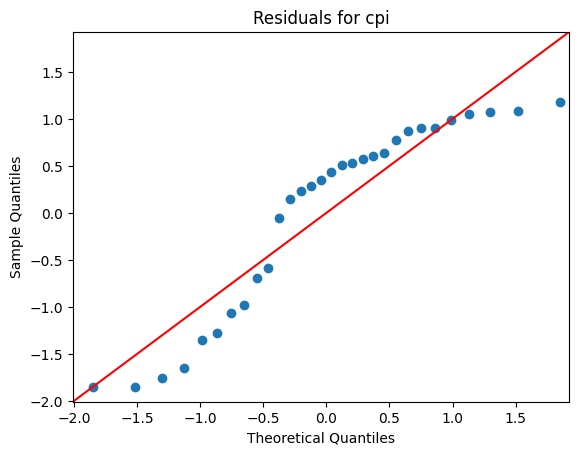

                               GEE Regression Results                              
Dep. Variable:                           S   No. Observations:                   30
Model:                                 GEE   No. clusters:                        3
Method:                        Generalized   Min. cluster size:                  10
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                10.0
Dependence structure:       Autoregressive   Num. iterations:                     7
Date:                     Mon, 30 Dec 2024   Scale:                           0.024
Covariance type:                    robust   Time:                         11:34:32
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7059      0.043     16.336      0.000       0.621       0.791
regulat

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/genmod/cov_struct.py:796: FutureWarning: grid=True will become default in a future version
  warnings.warn(


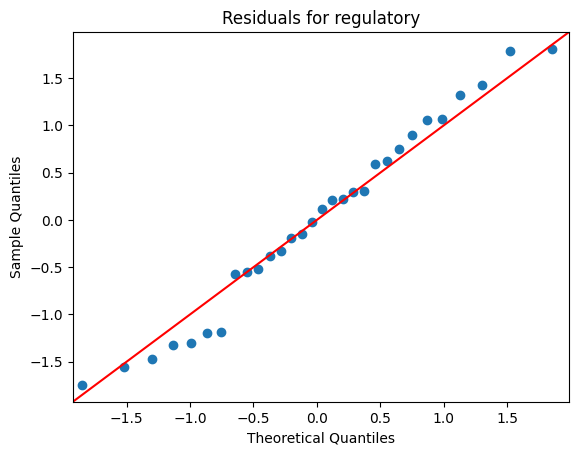

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/genmod/cov_struct.py:796: FutureWarning: grid=True will become default in a future version
  warnings.warn(


                               GEE Regression Results                              
Dep. Variable:                           S   No. Observations:                   30
Model:                                 GEE   No. clusters:                        3
Method:                        Generalized   Min. cluster size:                  10
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                10.0
Dependence structure:       Autoregressive   Num. iterations:                     7
Date:                     Mon, 30 Dec 2024   Scale:                           0.028
Covariance type:                    robust   Time:                         11:34:32
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7075      0.059     12.010      0.000       0.592       0.823
tariff 

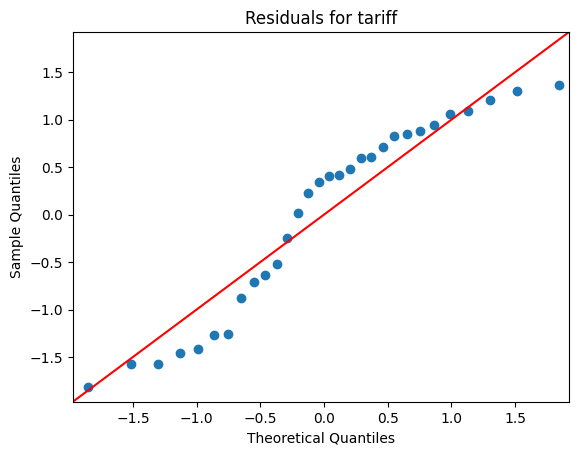

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/genmod/cov_struct.py:796: FutureWarning: grid=True will become default in a future version
  warnings.warn(


                               GEE Regression Results                              
Dep. Variable:                           S   No. Observations:                   30
Model:                                 GEE   No. clusters:                        3
Method:                        Generalized   Min. cluster size:                  10
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                10.0
Dependence structure:       Autoregressive   Num. iterations:                    19
Date:                     Mon, 30 Dec 2024   Scale:                           0.016
Covariance type:                    robust   Time:                         11:34:33
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.7117      0.038     18.552      0.000       0.637       0.787
f

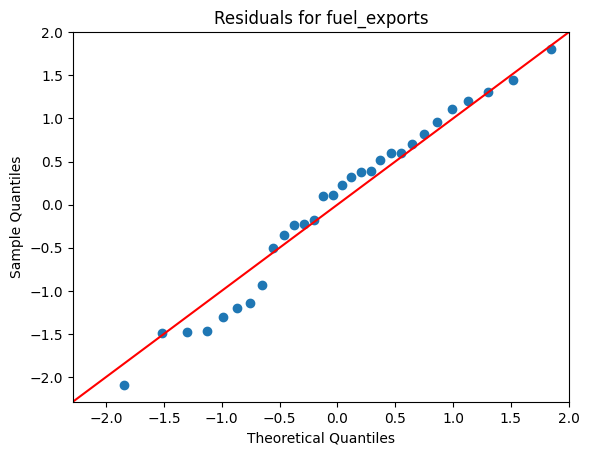

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/genmod/cov_struct.py:796: FutureWarning: grid=True will become default in a future version
  warnings.warn(


                               GEE Regression Results                              
Dep. Variable:                           S   No. Observations:                   30
Model:                                 GEE   No. clusters:                        3
Method:                        Generalized   Min. cluster size:                  10
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                10.0
Dependence structure:       Autoregressive   Num. iterations:                     6
Date:                     Mon, 30 Dec 2024   Scale:                           0.028
Covariance type:                    robust   Time:                         11:34:33
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.7001      0.053     13.096      0.000       0.595       0.805
f

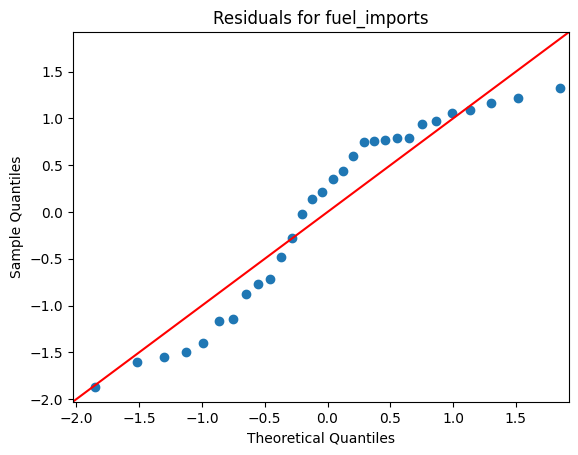

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/genmod/cov_struct.py:796: FutureWarning: grid=True will become default in a future version
  warnings.warn(


                               GEE Regression Results                              
Dep. Variable:                           S   No. Observations:                   30
Model:                                 GEE   No. clusters:                        3
Method:                        Generalized   Min. cluster size:                  10
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                10.0
Dependence structure:       Autoregressive   Num. iterations:                     6
Date:                     Mon, 30 Dec 2024   Scale:                           0.027
Covariance type:                    robust   Time:                         11:34:33
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.7053      0.050     14.059      0.000       0.60

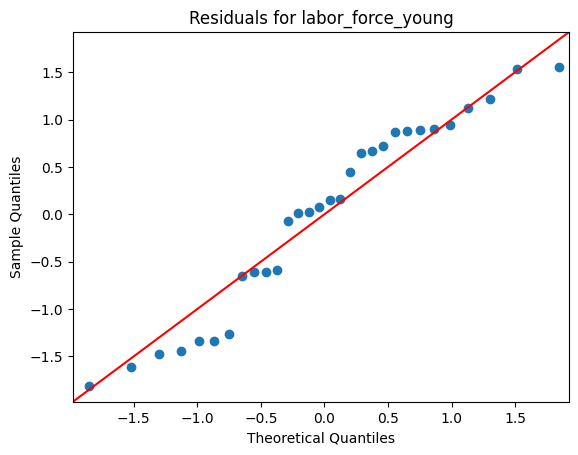

In [13]:
for indicator in indicators.keys():
    if indicator != "gdp":
        scalers[indicator] = indicator_report1(wb_data[indicator], indicator, target_data)

In [14]:
with open(os.path.dirname(os.getcwd()) + "/model_data/global_capture_production.pkl", "rb") as file:
    global_capture_production = pickle.load(file)

In [15]:
gcp_long = (
    global_capture_production.melt(
        id_vars=["Country", "Species", "Area"], var_name="Year", value_name="Capture"
    )
    .dropna()
    .reset_index(drop=True)
)

capture = (
    gcp_long.groupby(["Year", "Country", "Area"])
    .sum()
    .reset_index()[["Year", "Country", "Area", "Capture"]]
)

In [16]:
def capture_ratio(capture, economies, area):
    ec = ["FLK" if c == "GBR" else c for c in economies]
    capture_ec = capture[capture["Country"].isin(ec)].reset_index()
    capture_ec = capture_ec[capture_ec["Area"] == area]
    capture_ec["Total_Capture"] = capture_ec.groupby(["Year", "Area"])[
        "Capture"
    ].transform("sum")
    capture_ec["Capture_Ratio"] = capture_ec["Capture"] / capture_ec["Total_Capture"]
    capture_ec = capture_ec.fillna(0)[["Year", "Country", "Capture_Ratio"]]
    capture_ec["Country"] = capture_ec["Country"].replace("FLK", "GBR")
    capture_ec = (
        capture_ec.pivot(index="Year", columns="Country", values="Capture_Ratio")
        .reset_index()
        .rename(columns={"index": "Year"})
    )
    return capture_ec

In [32]:
capture_data = {}
for area in [41, 61, 81]:
    capture_data[area] = capture_ratio(capture, economies[area], area)

In [18]:
def weighted_ave(data, capture_data, area, years):
    countries = [c for c in economies[area] if c in data.columns]
    df = data.copy()
    capture_area = (
        capture_data[area][capture_data[area]["Year"].isin(years)]
        .reset_index()
        .drop("index", axis=1)
    )
    df["Weighted_Ave"] = sum(
        df[c] * capture_area[c] / sum(capture_area[coun] for coun in countries)
        for c in countries
    )
    df["Area"] = [area] * len(df)
    return df[["Year", "Weighted_Ave", "Area"]]

In [19]:
def indicator_report2(indicator_data, indicator_name, target_data, capture_data):
    comb = pd.DataFrame()

    for area, data in indicator_data.items():
        countries = [c for c in data.columns if c != "Year"]

        r = weighted_ave(data, capture_data, area, years, countries)

        if comb.empty:
            comb = r
        else:
            comb = pd.concat([comb, r])

    full_data = pd.merge(target_data, comb, how="inner", on=["Year", "Area"])

    sc = StandardScaler()
    X = sc.fit_transform(full_data["Weighted_Ave"].to_frame())
    X = pd.DataFrame(X, columns=["Weighted_Ave"])
    data = pd.concat([X, full_data[["S", "Area"]]], axis=1)

    
    ind = sm.cov_struct.Autoregressive()
    model = smf.gee("S ~ Weighted_Ave", "Area", data, cov_struct=ind)
    print(model.summary())

    fig = sm.qqplot(model.resid, stats.t, fit=True, line="45")
    plt.title(f"Residuals for {indicator_name}")
    plt.show()

    fig = sm.graphics.plot_regress_exog(model, "Weighted_Ave")
    plt.show()

In [20]:
for indicator in indicators.keys():
    indicator_report2(wb_data[indicator], indicator, target_data, capture_data)

TypeError: weighted_ave() takes 4 positional arguments but 5 were given

We find negative elasticity with CPI (Increase in prices means less sustainability -- makes sense) and positive elasticity with country regulatory estimate (Better regulations means more sustainable fishing practices -- makes sense). 

Should probe CPI further with time lags, seeing when the increase in prices drives less sustainable practices.

In [21]:
time_lag_data = {}
time_lag_indicators = {"cpi": indicators["cpi"], "gdp": indicators["gdp"]}
time_lag_years = list(range(1994, 2022))
time_lag = 10

for indicator, code in time_lag_indicators.items():
    time_lag_data[indicator] = {}
    for area, econ in economies.items():
        time_lag_data[indicator][area] = preprocess_wb_data(code, time_lag_years, econ)

In [22]:
def time_lag_report1(indicator_data, indicator_name, target_data):
    comb = pd.DataFrame()

    for area, data in indicator_data.items():
        r = regular_ave(data, area)
        lagged_df = pd.DataFrame()

        for i in range(time_lag + 1):
            years_lagged = years + i - time_lag
            r_lag = r[r["Year"].isin(years_lagged)]
            lagged_df[f"t_{time_lag-i}"] = r_lag.reset_index()["Ave"]

        lagged_df["Area"] = [area] * len(lagged_df)
        lagged_df["Year"] = years
        if comb.empty:
            comb = lagged_df.copy()
        else:
            comb = pd.concat([comb, lagged_df])

    comb = pd.concat(
        [comb, pd.get_dummies(comb["Area"], prefix="Area", dtype=int)], axis=1
    )

    sc = StandardScaler()
    X = sc.fit_transform(comb[[f"t_{time_lag-i}" for i in range(time_lag + 1)]])
    X = sm.add_constant(X)
    X = pd.DataFrame(
        X, columns=["const"] + [f"t_{time_lag-i}" for i in range(time_lag + 1)]
    )
    X = pd.concat([X, comb["Area"].reset_index(drop=True)], axis=1)
    Y = target_data["S"].reset_index(drop=True)

    formula = "S ~ " + " + ".join([f"t_{t}" for t in range(time_lag + 1)])

    mixed_model = smf.mixedlm(
        formula,
        pd.concat([Y, X.drop(columns="const")], axis=1),
        groups=X["Area"],
    ).fit()
    print(mixed_model.summary())

    area_one_hot = comb[[f"Area_{area}" for area in economies.keys()]].reset_index(
        drop=True
    )
    X = pd.concat([X.drop(columns="Area"), area_one_hot], axis=1)
    

    model = sm.OLS(Y, X).fit()
    print(model.summary())

    fig = sm.qqplot(model.resid, stats.t, fit=True, line="45")
    plt.title(f"Residuals for {indicator_name}")
    plt.show()

    for i in range(time_lag + 1):
        fig = sm.graphics.plot_regress_exog(model, f"t_{time_lag-i}")
        plt.show()

    return sc

In [23]:
print(time_lag_data["cpi"][41])

economy  Year         BRA         GBR         URY
0        1994   22.071544   71.990013   16.201621
1        1995   36.640316   73.931940   23.046534
2        1996   42.413974   76.040318   29.578394
3        1997   45.351868   77.714074   35.440480
4        1998   46.800895   79.128907   39.271975
5        1999   49.074692   80.515998   41.494254
6        2000   52.531583   81.468467   43.470967
7        2001   56.124932   82.716849   45.366015
8        2002   60.867581   83.974478   51.704769
9        2003   69.824196   85.130387   61.725013
10       2004   74.430628   86.314037   67.377546
11       2005   79.543667   88.117255   70.543804
12       2006   82.871431   90.281117   75.056950
13       2007   85.889006   92.435731   81.147555
14       2008   90.766294   95.690771   87.539608
15       2009   95.202982   97.567967   93.721846
16       2010  100.000000  100.000000  100.000000
17       2011  106.636450  103.856112  108.092832
18       2012  112.398549  106.528574  116.845936


In [30]:
def save_timelag_data(time_lag_data, target_data, capture_data=None):
    scales = {}
    for indicator, indicator_data in time_lag_data.items():
        comb = pd.DataFrame()
        max_value = 0
        for area, data in indicator_data.items():
            d = data[[col for col in data.columns if col != "Year"]]
            if max_value < d.max().max():
                max_value = d.max().max()
            if capture_data:
                r = weighted_ave(data, capture_data, area, range(2004-time_lag, 2022))
            else:
                r = regular_ave(data, area)
            lagged_df = pd.DataFrame()

            for i in range(time_lag + 1):
                years_lagged = years + i - time_lag
                r_lag = r[r["Year"].isin(years_lagged)]
                lagged_df[f"t_{time_lag-i}"] = r_lag.reset_index()["Ave"]

            lagged_df["Area"] = [area] * len(lagged_df)
            lagged_df["Year"] = years
            if comb.empty:
                comb = lagged_df.copy()
            else:
                comb = pd.concat([comb, lagged_df])

        scale = (10 ** math.floor(math.log10(max_value)))
        comb[[f"t_{time_lag-i}" for i in range(time_lag + 1)]] = comb[[f"t_{time_lag-i}" for i in range(time_lag + 1)]] / scale
        comb = comb.merge(target_data, how="inner", on=["Area", "Year"])
                
        scales[indicator] = scale
        
        name = "weighted_ave" if capture_data else "ave"
        
        with open(os.path.join(os.path.dirname(os.getcwd()), f"model_data/{indicator}_{name}.pkl"), "wb") as file:
            pickle.dump(comb, file)
            
            

In [33]:
save_timelag_data(time_lag_data, target_data)
save_timelag_data(time_lag_data, target_data, capture_data)

KeyError: 'ARG'

          Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  S       
No. Observations:  30       Method:              REML    
No. Groups:        3        Scale:               28.2906 
Min. group size:   10       Log-Likelihood:      -50.6508
Max. group size:   10       Converged:           Yes     
Mean group size:   10.0                                  
---------------------------------------------------------
           Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
---------------------------------------------------------
Intercept   69.876   12.451  5.612 0.000   45.473  94.279
t_0         12.424   23.748  0.523 0.601  -34.120  58.969
t_1        -48.705   41.003 -1.188 0.235 -129.069  31.659
t_2         98.604   48.579  2.030 0.042    3.390 193.817
t_3       -106.521   42.113 -2.529 0.011 -189.062 -23.981
t_4         63.836   46.741  1.366 0.172  -27.775 155.447
t_5        -85.303   38.304 -2.227 0.026 -160.376 -10.229
t_6         72.029   36.

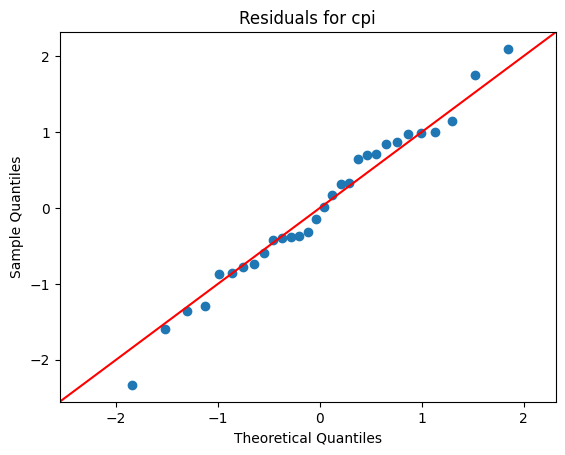

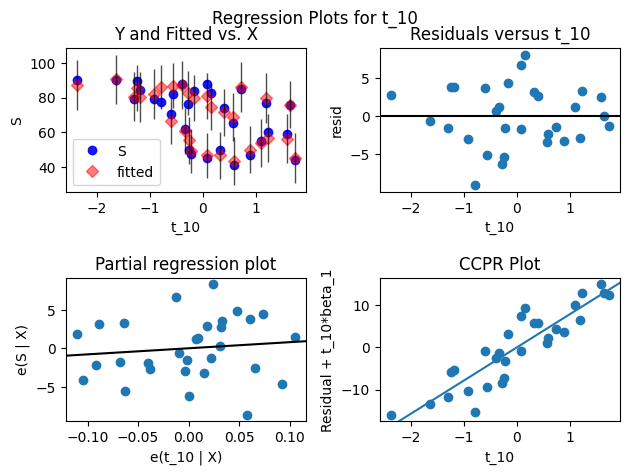

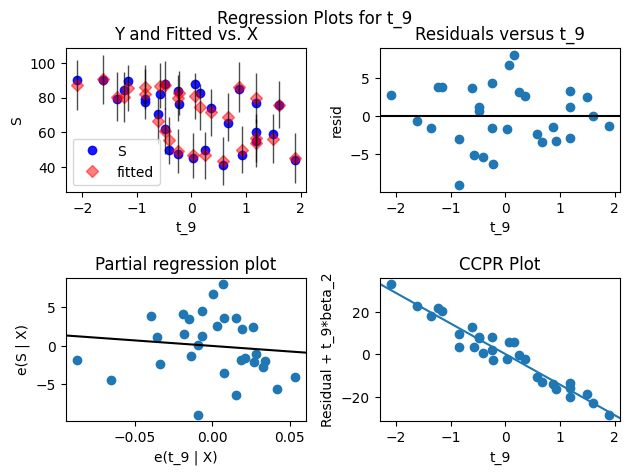

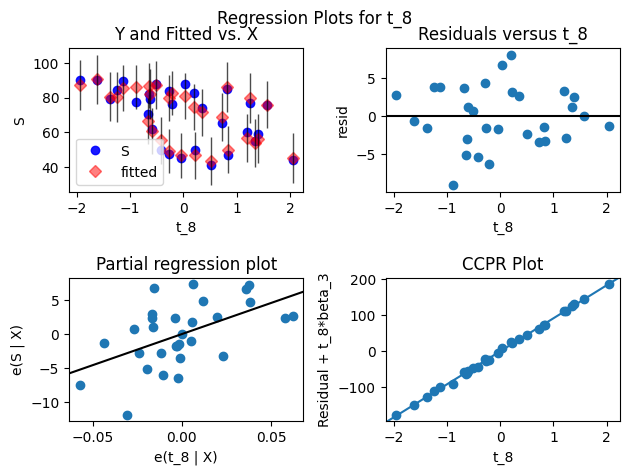

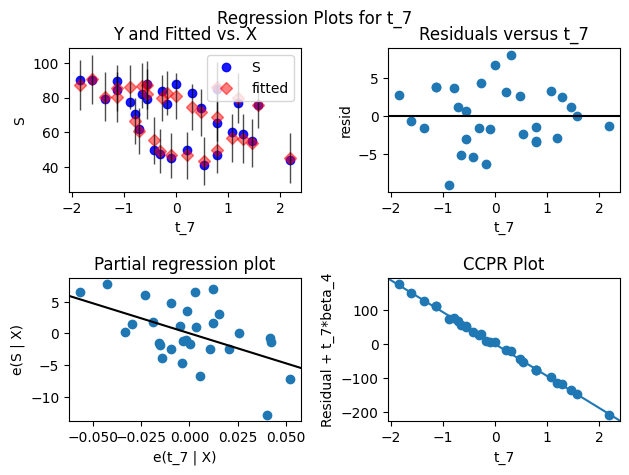

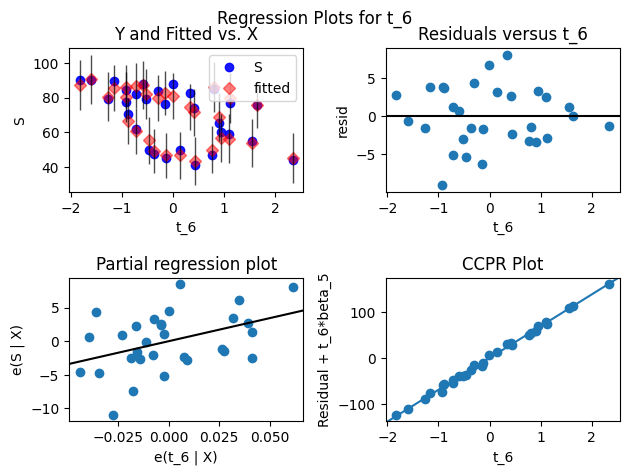

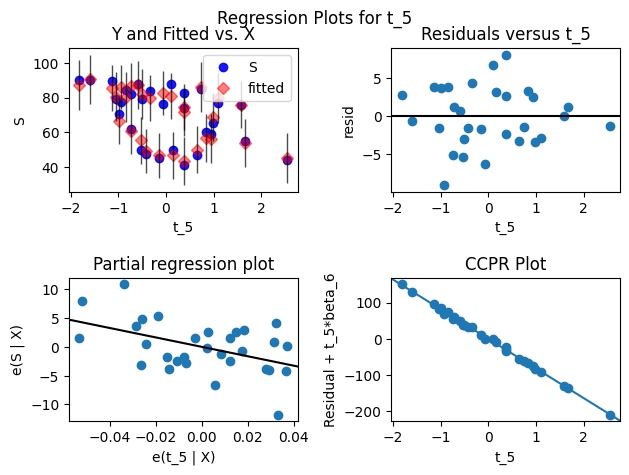

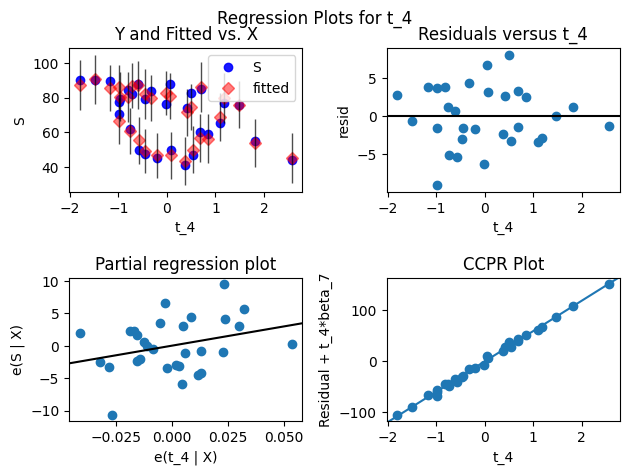

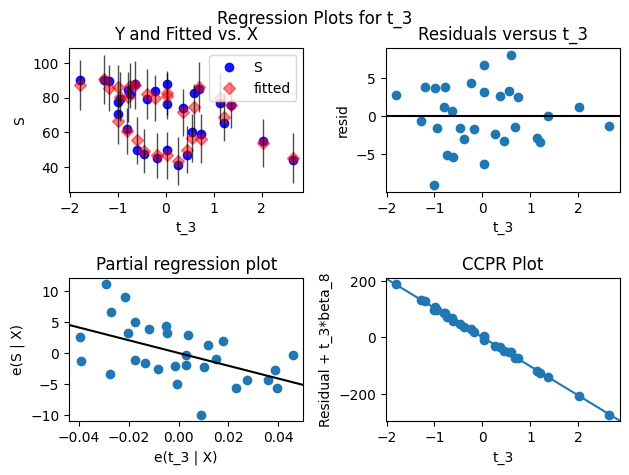

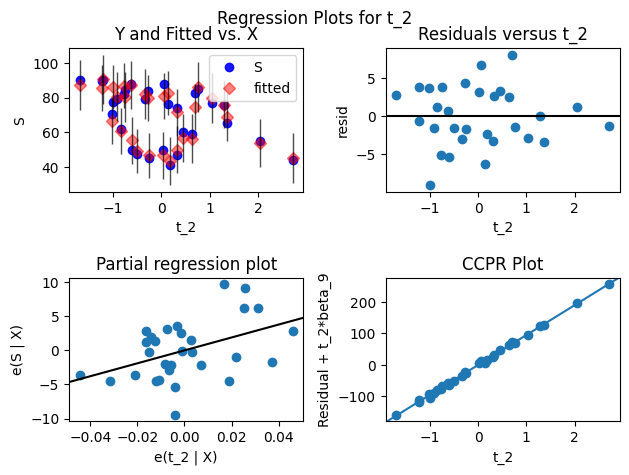

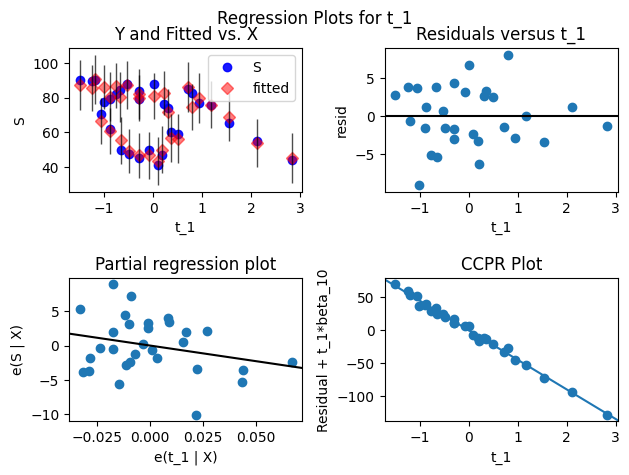

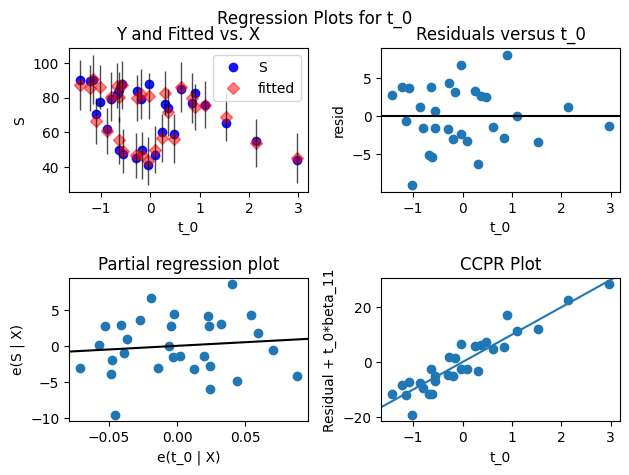

StandardScaler()

In [ ]:
time_lag_report1(time_lag_data["cpi"], "cpi", target_data)

          Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  S       
No. Observations:   30       Method:              REML    
No. Groups:         3        Scale:               121.1702
Min. group size:    10       Log-Likelihood:      -51.1300
Max. group size:    10       Converged:           Yes     
Mean group size:    10.0                                  
----------------------------------------------------------
           Coef.   Std.Err.   z    P>|z|  [0.025   0.975] 
----------------------------------------------------------
Intercept   69.876   11.871  5.886 0.000   46.608   93.143
t_0         85.159  155.283  0.548 0.583 -219.190  389.508
t_1         -6.786  169.149 -0.040 0.968 -338.312  324.741
t_2        -64.704  248.039 -0.261 0.794 -550.852  421.443
t_3        309.143  508.532  0.608 0.543 -687.561 1305.847
t_4       -123.716  309.040 -0.400 0.689 -729.424  481.992
t_5       -293.653  328.074 -0.895 0.371 -936.666  349.359
t_6     

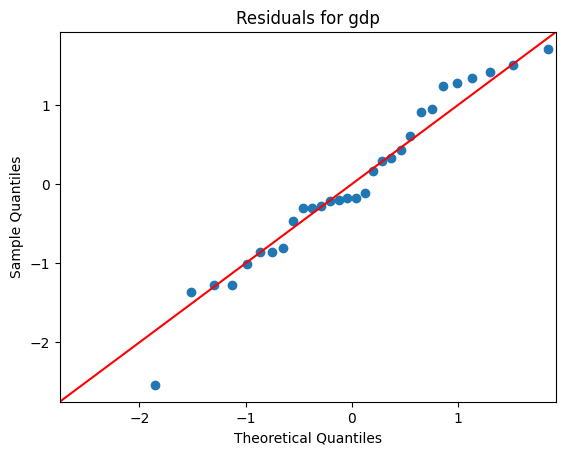

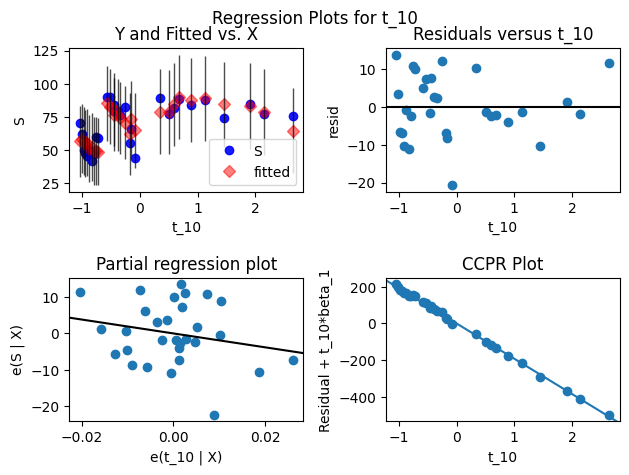

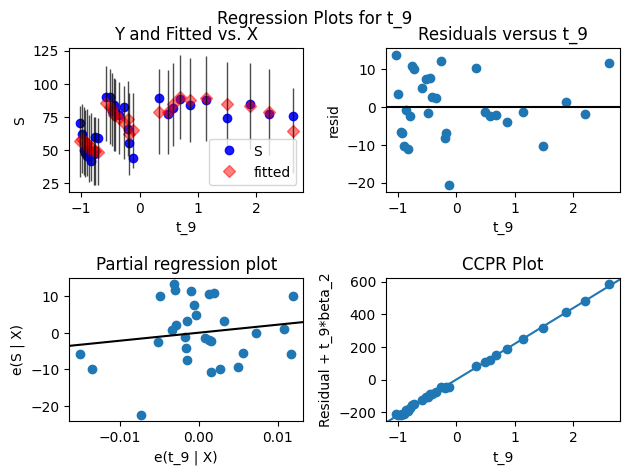

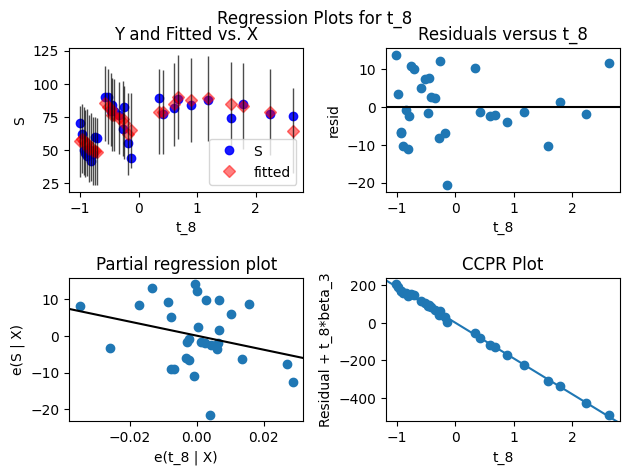

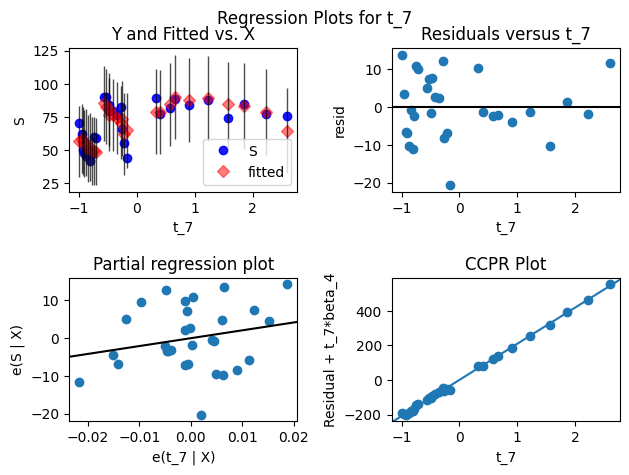

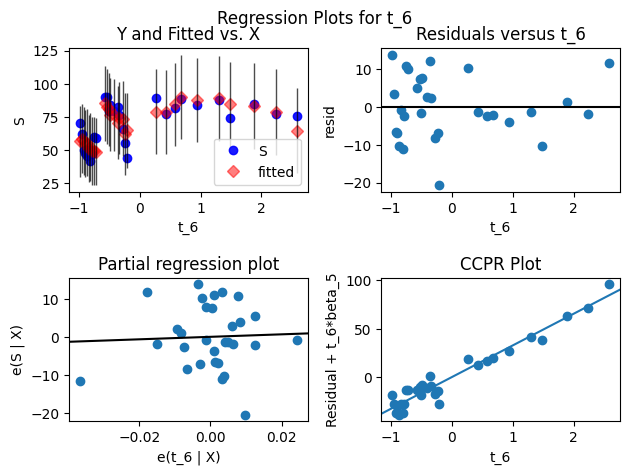

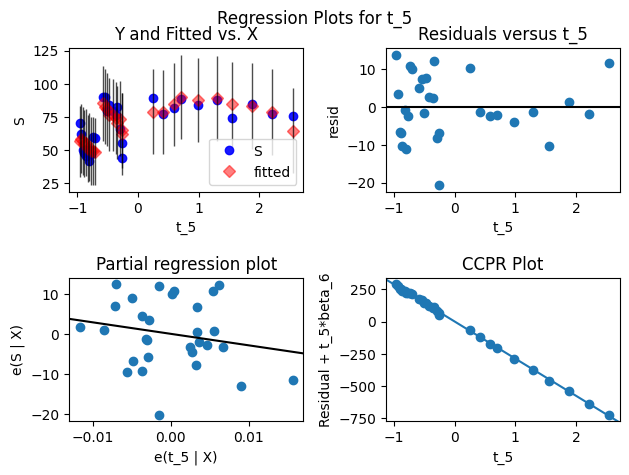

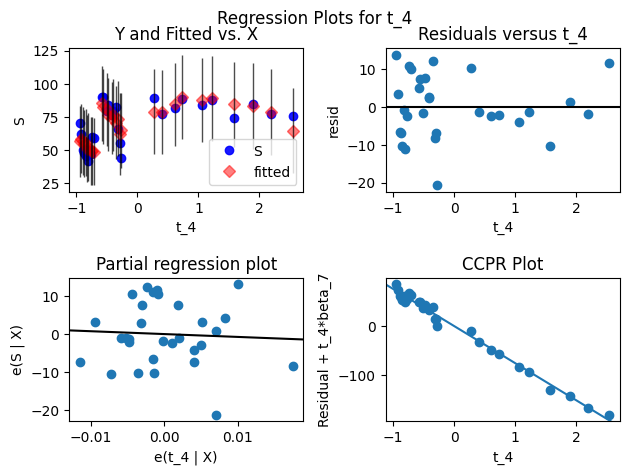

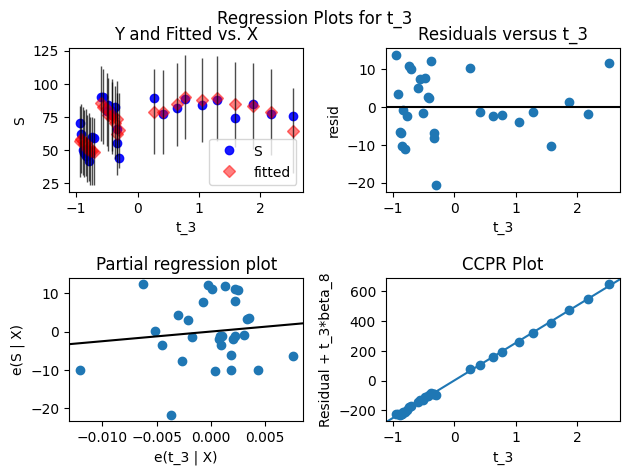

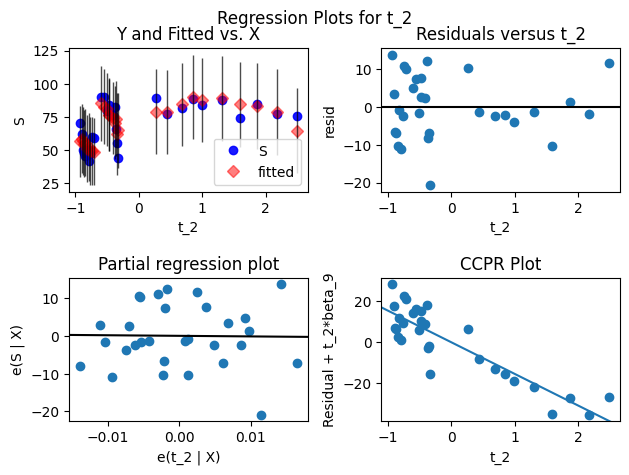

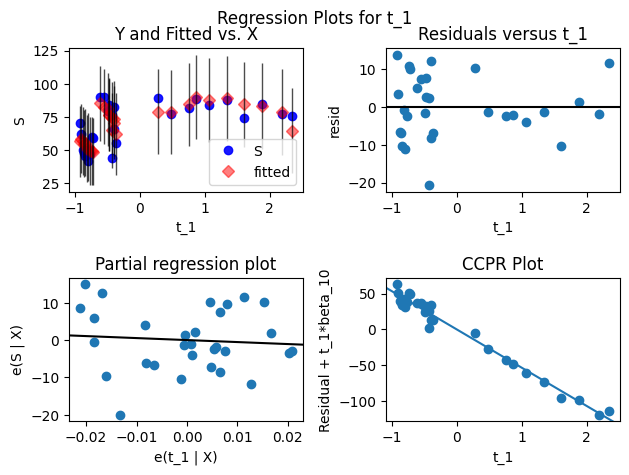

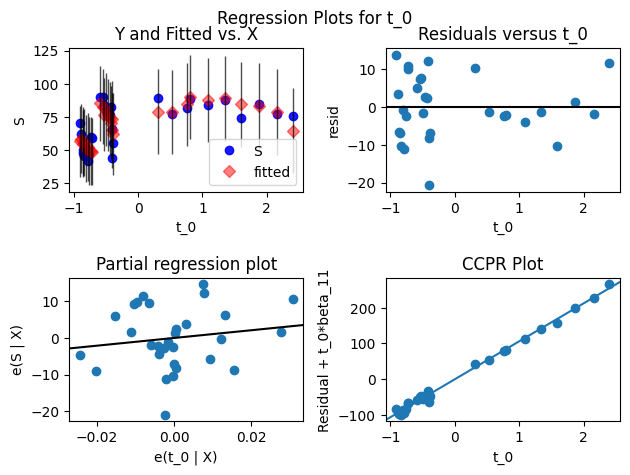

StandardScaler()

In [ ]:
time_lag_report1(time_lag_data["gdp"], "gdp", target_data)

In [ ]:
def indicator_report3(indicator_data, indicator_name, target_data, formula=False):
    comb = pd.DataFrame()

    for area, data in indicator_data.items():
        r = regular_ave(data, area)

        if comb.empty:
            comb = r
        else:
            comb = pd.concat([comb, r])

    full_data = pd.merge(target_data, comb, how="inner", on=["Year", "Area"])

    sc = StandardScaler()
    X = sc.fit_transform(full_data["Ave"].to_frame())
    # X = sm.add_constant(X)
    X = pd.DataFrame(X, columns=[indicator_name])
    data = pd.concat([full_data[["S", "Area"]], X], axis=1)

    md = smf.mixedlm(
        f"S ~ {indicator_name}",
        data,
        groups=data["Area"],
        re_formula=f"~{indicator_name}" if formula else None,
    )
    mdf = md.fit()
    print(mdf.summary())

    return sc

In [ ]:
for indicator in indicators.keys():
    indicator_report3(wb_data[indicator], indicator, target_data)

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: S        
No. Observations: 30      Method:             REML     
No. Groups:       3       Scale:              97.3156  
Min. group size:  10      Log-Likelihood:     -110.1006
Max. group size:  10      Converged:          Yes      
Mean group size:  10.0                                 
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    69.876    7.731  9.039 0.000 54.724 85.028
cpi          -4.744    1.876 -2.530 0.011 -8.420 -1.068
Group Var   169.554   18.942                           

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: S        
No. Observations: 30      Method:             REML     
No. Groups:       3       Scale:              47.8420  
Min. group size:  10      Log-Likelihood:     -101.4729
Max. grou